##Import e style

In [33]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from glob import glob
import shutil
from collections import defaultdict
import os
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

#Formattazione grafica
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)


RANDOM_SEED = 42   #Replicare l'esperimento
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()#Rende visibili le modifiche

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cpu')

## Importa dataser



In [5]:
!rm -rf GTSRB
!rm -rf data
!rm -rd GTSRB_Final_Training_Images.zip

rm: cannot remove 'GTSRB_Final_Training_Images.zip': No such file or directory


In [6]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip


--2022-07-08 15:46:22--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  19.7MB/s    in 15s     

2022-07-08 15:46:38 (17.5 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



### Exploration 


In [7]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*')) #glob restituisce i path che corrispondono
print("Classi:")
len(train_folders)

Classi:


43


CSV funzioni visualizzazione immagini

In [8]:
#Carica immagine
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)    #conversione BGR a RBG 

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

#Mostra immagine
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

#Mostra griglia di immagini
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Sample per ogni classe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


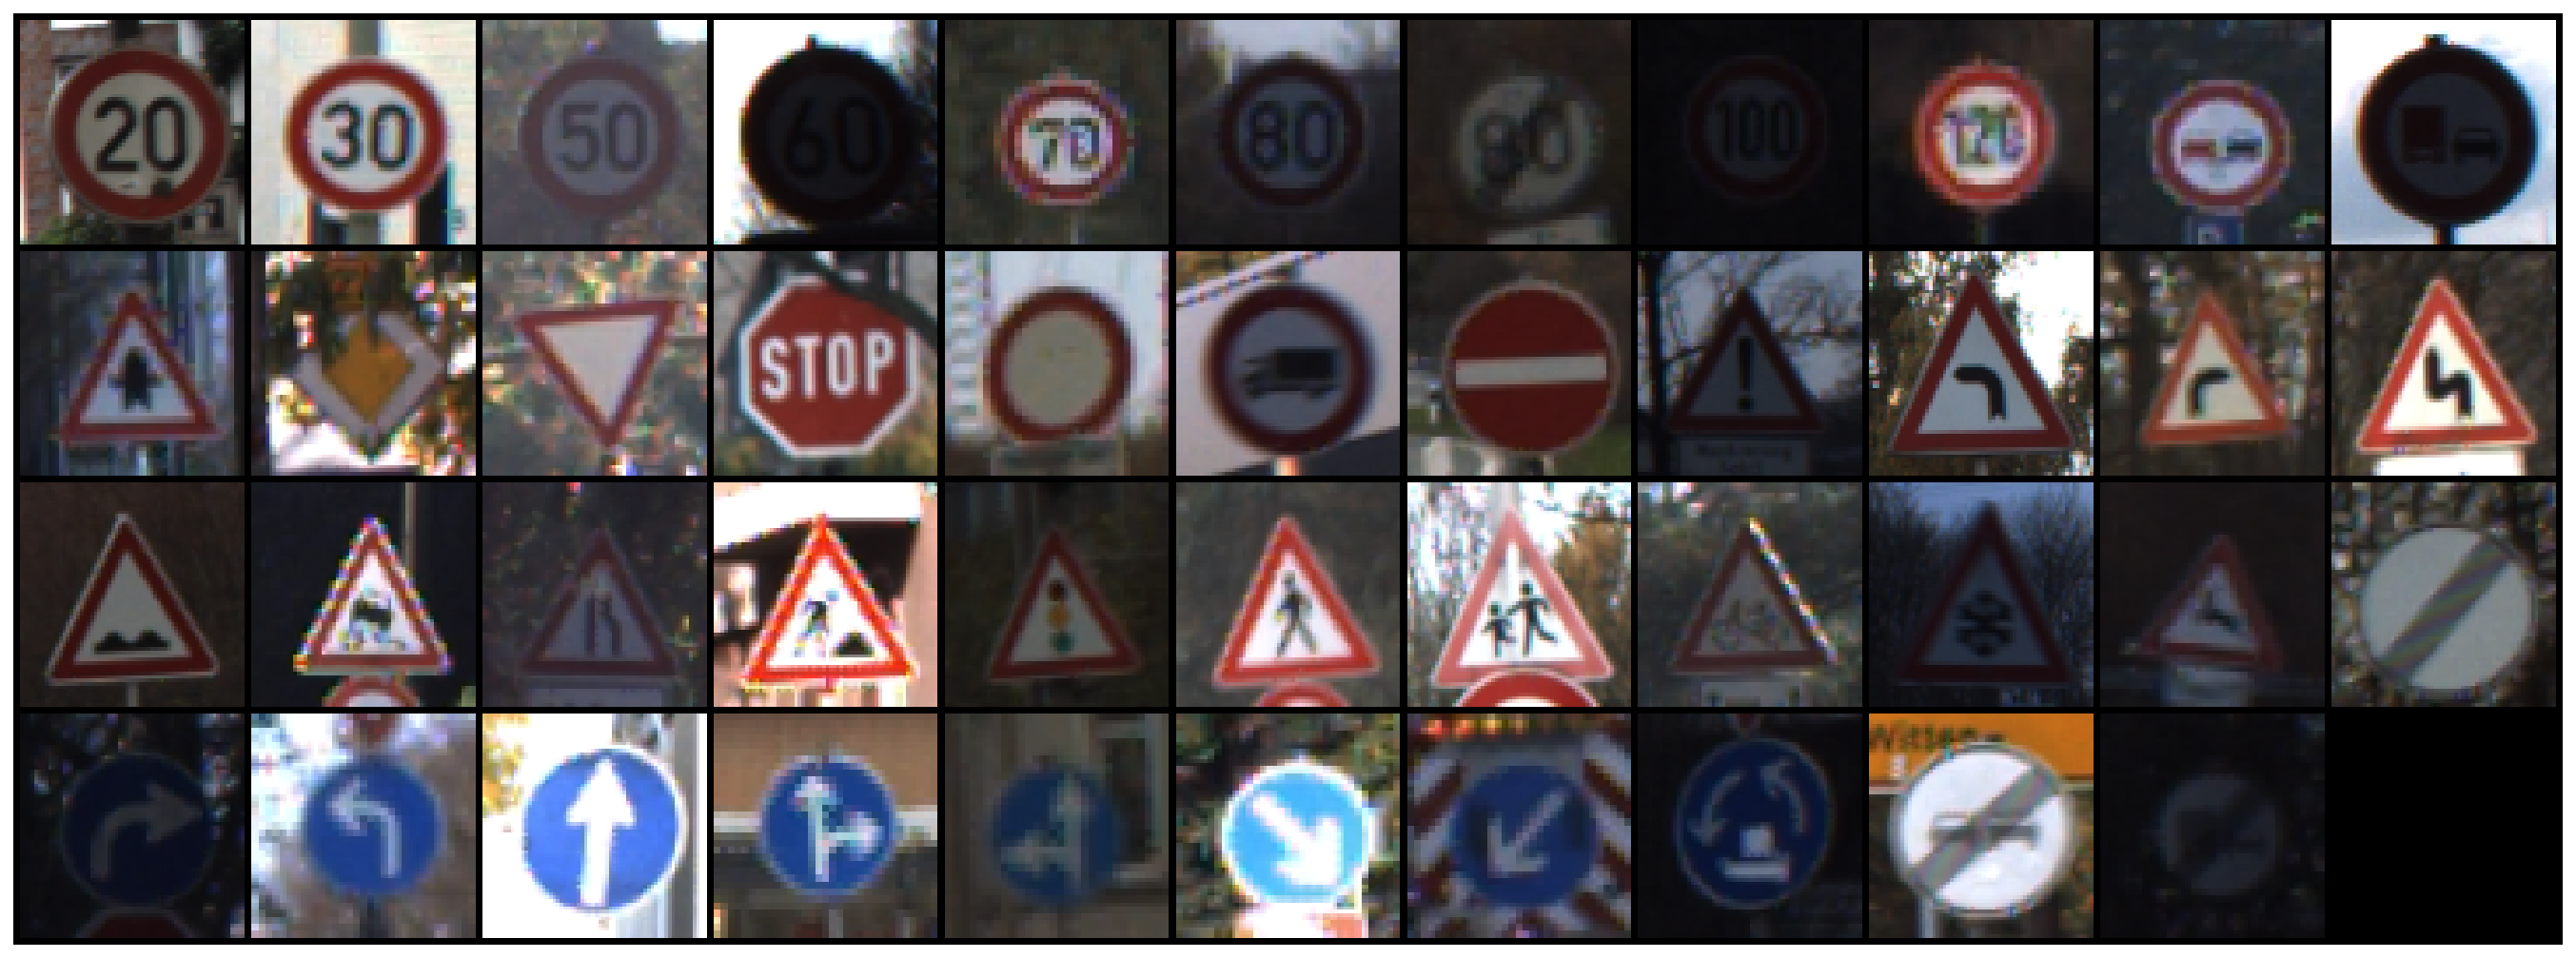

In [9]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]   #np.random.choice restituisce un elemento random dell'array
show_sign_grid(sample_images)                                                    #con f'{x}/*ppm' la stringa viene calcolara a runtime 

Singola immagine

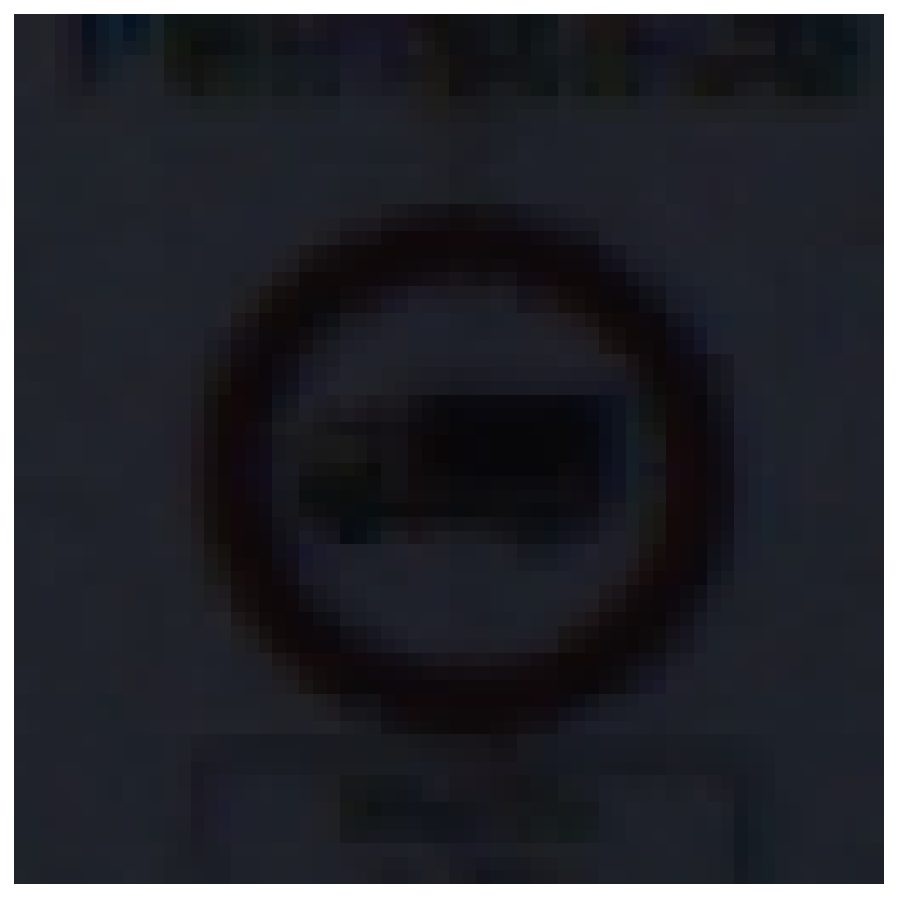

In [10]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

## Building dataset


In [11]:
'''class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [13, 14, 15, 18]
'''

class_names = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 
    'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 
    'End of speed limit (80km/h)', 'Speed limit (100km/h)', 
    'Speed limit (120km/h)', 'No passing', 
    'No passing for vehicles over 3.5 metric tons', 
    'Right-of-way at the next intersection', 'Priority road', 'Yield (give_way)', 
    'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 
    'No entry', 'General caution', 'Dangerous curve to the left', 
    'Dangerous curve to the right', 'Double curve', 'Bumpy road', 
    'Slippery road', 'Road narrows on the right', 'Road work', 
    'Traffic signals', 'Pedestrians', 'Children crossing', 
    'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 
    'End of all speed and passing limits', 'Turn right ahead', 
    'Turn left ahead', 'Ahead only', 'Go straight or right', 
    'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 
    'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']

class_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                 41, 42]


copia immagini nelle directory per ogni classe (semplifica torchvision's dataset helper)

In [12]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

**80% training, 10% validation, 10% test per ogni classe** (Nella corrispettiva cartella)

In [13]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')   # Copy the content of source to destination

Speed limit (20km/h): 210
Speed limit (30km/h): 2220
Speed limit (50km/h): 2250
Speed limit (60km/h): 1410
Speed limit (70km/h): 1980
Speed limit (80km/h): 1860
End of speed limit (80km/h): 420
Speed limit (100km/h): 1440
Speed limit (120km/h): 1410
No passing: 1470
No passing for vehicles over 3.5 metric tons: 2010
Right-of-way at the next intersection: 1320
Priority road: 2100
Yield (give_way): 2160
Stop: 780
No vehicles: 630
Vehicles over 3.5 metric tons prohibited: 420
No entry: 1110
General caution: 1200
Dangerous curve to the left: 210
Dangerous curve to the right: 360
Double curve: 330
Bumpy road: 390
Slippery road: 510
Road narrows on the right: 270
Road work: 1500
Traffic signals: 600
Pedestrians: 240
Children crossing: 540
Bicycles crossing: 270
Beware of ice/snow: 450
Wild animals crossing: 780
End of all speed and passing limits: 240
Turn right ahead: 689
Turn left ahead: 420
Ahead only: 1200
Go straight or right: 390
Go straight or left: 210
Keep right: 2070
Keep left: 300

##Il dataset è sbilanciato, applico trasformazioni per **"Augmentation"**

In [14]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=20),
  T.RandomErasing(), #cancella autonomamente parti dell'immagine
  AddGaussianNoise(0.1, 0.08),  #rumore gaussiano (vero e proprio "rumore del sensore", disturbo)
  T.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0), #modifica condizioni foto
  T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), #blur

  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Cereo dataset PyTorch per ogni "image dataset folder" e "data loaders" per semplificare training


In [15]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Salvo numero di example e nome delle classi in ogni dataset

In [16]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 3921, 'train': 31367, 'val': 3921}



Visualizza immagini dopo trasformazioni (reverse della normalizzazione e dei canali colore)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


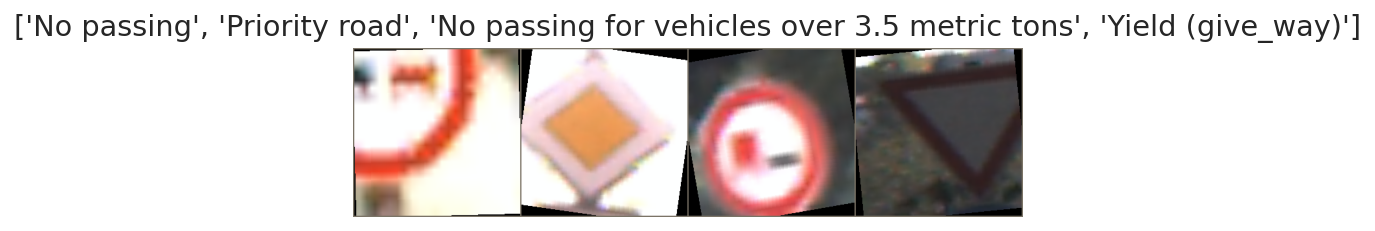

In [36]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Creo Modello
(Più modelli in base all'input per confronto)

Il layer di output deve essere sostituito per combaciare con il numero di output ed essere addestrato

In [18]:
def create_model(net_model, n_classes):

  if(net_model=='resnet18'):
    model = models.resnet18(pretrained = True, progress = True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if (net_model == 'alexnet'):
    model = models.alexnet(pretrained = True, progress = True)
    n_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(n_features,n_classes)

  if(net_model == 'googleLeNet'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if(net_model=='mobilenet_v2'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, n_classes)

  if(net_model=='mobilenet_v3'):
    model = models.mobilenet_v3_small(pretrained=True, progress=True)
    model.classifier[-1] = nn.Linear(1024, n_classes)

  if(net_model == 'shufflenet_v2'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)
    model.fc = nn.Linear(1024, n_classes)

  if(net_model == 'efficientnet_b0'):
    model = models.efficientnet_b0(pretrained=True, progress=True)
    model.classifier[1] = nn.Linear(in_features=1280, out_features=n_classes)

#  if(net_model == 'NASNet-A-Mobile'):
#    #model = timm.create_model('nasnetalarge', pretrained=True, num_classes=NUM_FINETUNE_CLASSES)
#    #nasnetamobile(num_classes=1000, pretrained='imagenet')
#    model = models.nasnetmobile(pretrained = True, progress=True)


    #model = models.mobilenet_v3_small(pretrained=True, progress=True)
    #print(model.classifier) 

  return model.to(device)

### Training
Modello in train-mode. Si cicla sugli input e le lora label, si ottiene la predizione (classe con max prob) e si calcola loss ed accuracy

In [19]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  
  #Calcolo gradiente attivo
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()
  accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)

##Evaluating
Simile al training ma effettuato sul validation per verificare il modello e non calcola gradiente

In [20]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  #Calcolo gradiente inattivo
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)


##Training completo

L'History salva le performance, pytorch salva il "miglior modello" ed i suoi pesi ottenuti durante il training

In [21]:
                                                                    #30
def train_model(model,net, data_loaders, dataset_sizes, device, n_epochs=10):

  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  PATH = 'drive/MyDrive/Modelli'
  if(net=='resnet18'):
    PATH = 'drive/MyDrive/Modelli/resnet18/resnet18.pt'

  if (net == 'alexnet'):
    PATH = 'drive/MyDrive/Modelli/alexnet/alexnet.pt'

  if(net == 'googleLeNet'):
    PATH = 'drive/MyDrive/Modelli/googleLeNet/googleLeNet.pt'

  if(net=='mobilenet_v2'):
    PATH = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v2.pt'

  if(net=='mobilenet_v3'):
    PATH = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v3.pt'

  if(net == 'shufflenet_v2'):
    PATH = 'drive/MyDrive/Modelli/shufflenet_v2/shufflenet_v2.pt'

  if(net == 'efficientnet_b0'):
    PATH = 'drive/MyDrive/Modelli/efficientnet_b0/efficientnet_b0.pt'

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss}  accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss}  accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      #Salvataggio
      #torch.save(model.state_dict(), 'drive/MyDrive/Modelli/resnet18/resnet18_no_pretrain_no_augmentation.bin')
      torch.save(model.state_dict(), PATH)
      
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  torch.save(model.state_dict(), PATH)
  print("Model saved")

  
  return model, history


Scelta e training del modello:

##ResNet18

In [234]:
base_model = create_model("resnet18",len(class_names))

#comando time restituisce wall time della cella

In [235]:
%%time

base_model, history = train_model(base_model, 'resnet18', data_loaders, dataset_sizes, device)

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 2.5526267224635375  accuracy 0.2748748684923646
Val   loss 1.3962417150430844  accuracy 0.5575108390716653

Epoch 2/10
----------
Train loss 1.201127917480861  accuracy 0.644977205343195
Val   loss 0.3620149363266047  accuracy 0.9071665391481765

Epoch 3/10
----------
Train loss 0.6366561835056065  accuracy 0.817706506838397
Val   loss 0.12172304902763649  accuracy 0.9658250446314716

Epoch 4/10
----------
Train loss 0.39608844563132095  accuracy 0.8918289922530047
Val   loss 0.05715198591788048  accuracy 0.9875031879622544

Epoch 5/10
----------
Train loss 0.35899737071372034  accuracy 0.9013294226416296
Val   loss 0.06950276294076964  accuracy 0.98342259627646

Epoch 6/10
----------
Train loss 0.3474114105546285  accuracy 0.9030828577804698
Val   loss 0.05413880271956335  accuracy 0.9875031879622544

Epoch 7/10
----------
Train loss 0.32463996424024105  accuracy 0.9095227468358466
Val   loss 0.04987590839771369  accuracy 0.9897985207855139

Epoch 8/10
----------
Train loss

##AlexNet

In [168]:
%%time
base_model = create_model('alexnet', len(class_names))


base_model, history = train_model(base_model, 'alexnet', data_loaders, dataset_sizes, device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 1.4680951748552098  accuracy 0.586763158733701
Val   loss 0.4983196840803239  accuracy 0.8689109920938536

Epoch 2/2
----------
Train loss 0.7077853542115571  accuracy 0.8018937099499474
Val   loss 0.15397978678759017  accuracy 0.954858454475899

Best val accuracy: 0.954858454475899
Model saved
CPU times: user 5min 18s, sys: 21.6 s, total: 5min 40s
Wall time: 6min 25s


##GoogleLeNet

In [ ]:
%%time
base_model = create_model('googleLeNet', len(class_names))


base_model, history = train_model(base_model, 'googleLeNet', data_loaders, dataset_sizes, device)

##MobileNet_v2

In [ ]:
%%time
base_model = create_model('mobilenet_v2', len(class_names))


base_model, history = train_model(base_model, 'mobilenet_v2', data_loaders, dataset_sizes, device)

##MobileNet_v3

In [ ]:
%%time
base_model = create_model('mobilenet_v3', len(class_names))

base_model, history = train_model(base_model, 'mobilenet_v3' , data_loaders, dataset_sizes, device)

##ShuffleNet_v2

In [ ]:
%%time
base_model = create_model('shufflenet_v2', len(class_names))


base_model, history = train_model(base_model, 'shufflenet_v2', data_loaders, dataset_sizes, device)

##EfficientNet_b0

In [ ]:
%%time
base_model = create_model('efficientnet_b0', len(class_names))

base_model, history = train_model(base_model, 'efficientnet_b0', data_loaders, dataset_sizes, device)

##Visualizzazione History

In [22]:
def plot_training_history(history):
  #device = torch.device("cpu")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], 'o-', label='train loss')
  ax1.plot(history['val_loss'], '^-', label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 3.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], 'o-', label='train accuracy')
  #print("Sono qui")
  ax2.plot(history['val_acc'], '^-', label='validation accuracy')
  
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')
  fig.savefig('drive/MyDrive/Modelli/resnet18/resnet18.png')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

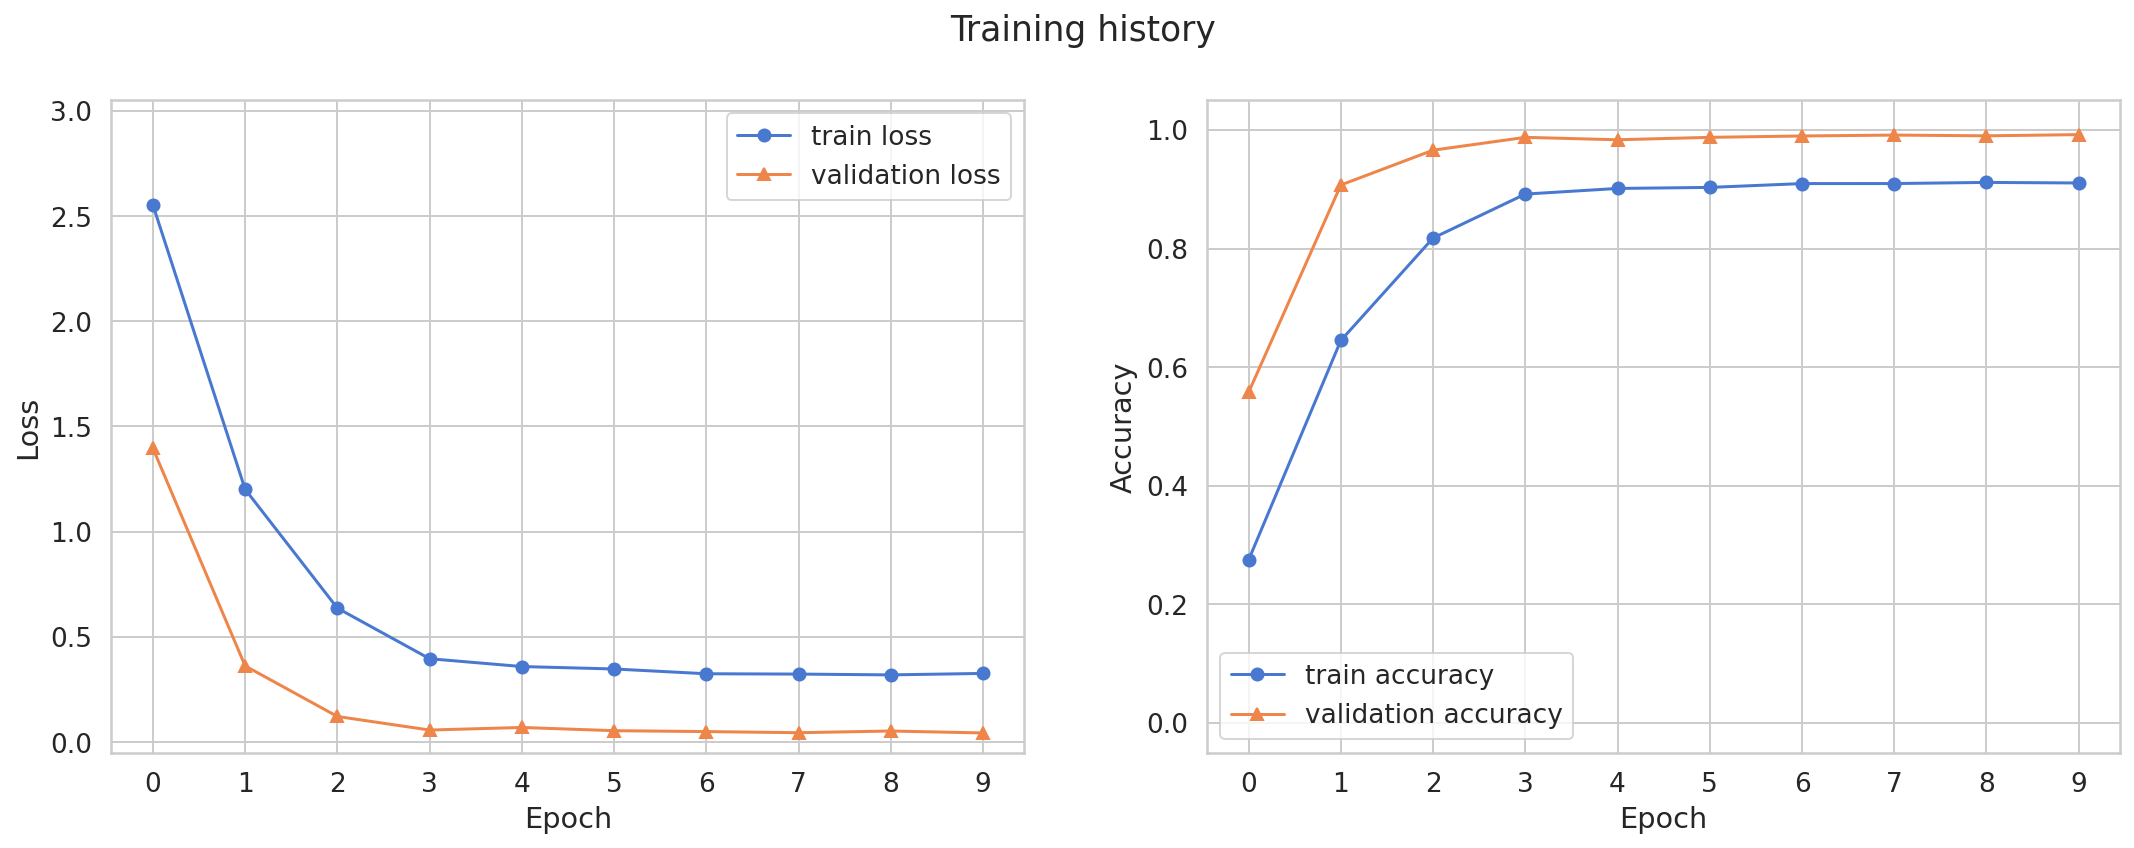

In [241]:
plot_training_history(history)


### Evaluation

Valutazione del modello sul TestSet. (No calcolo gradiente)

In [23]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


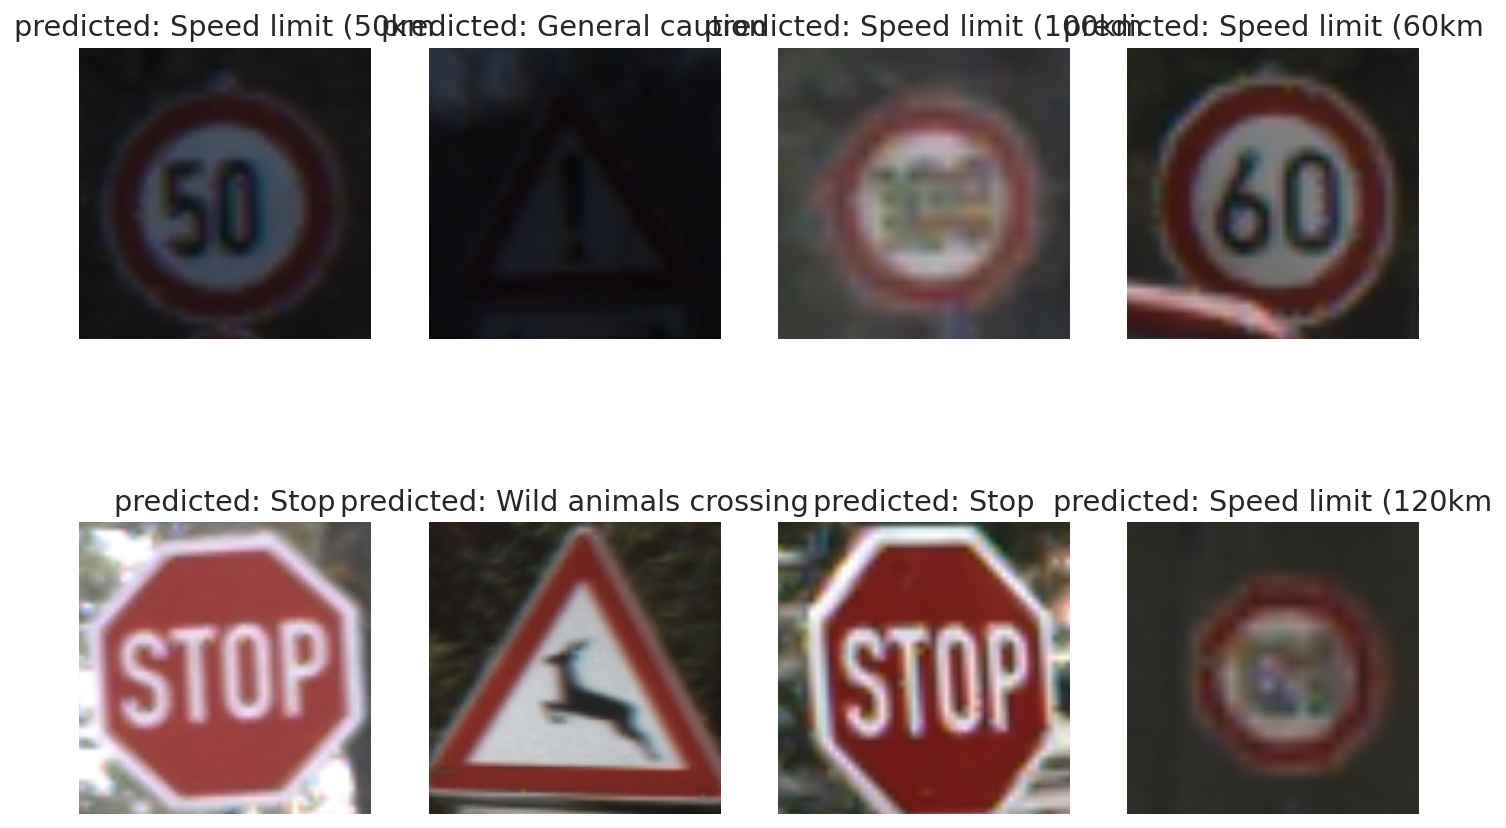

In [26]:
base_model = create_model('resnet18', 43)

#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18_no_pretrain_no_augmentation.pt',map_location=torch.device('cpu')))
base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/alexnet/resnet18.pt'))

      
show_predictions(base_model, class_names, n_images=8)

In [27]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [28]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])
#print(y_pred, y_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [29]:
print(classification_report(y_test, y_pred, target_names=class_names))
print("Accuracy:",accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))
print()
'''def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

print("Accuracy: .3f", )
from sklearn.metrics import accuracy_score
print('Test accuracy: ',accuracy_score(labels, classes_x)*100)'''

                                                    precision    recall  f1-score   support

                                        Ahead only       1.00      0.99      1.00       120
                                     Beware of ice       0.98      1.00      0.99        45
                                 Bicycles crossing       0.96      1.00      0.98        27
                                        Bumpy road       1.00      1.00      1.00        39
                                 Children crossing       0.98      0.94      0.96        54
                       Dangerous curve to the left       1.00      0.95      0.98        21
                      Dangerous curve to the right       0.88      1.00      0.94        36
                                      Double curve       1.00      0.97      0.98        33
               End of all speed and passing limits       0.96      1.00      0.98        24
                                 End of no passing       0.96      1.00      0.

'def calculate_accuracy(y_pred, y):\n    top_pred = y_pred.argmax(1, keepdim = True)\n    correct = top_pred.eq(y.view_as(top_pred)).sum()\n    acc = correct.float() / y.shape[0]\n    return acc\n\nprint("Accuracy: .3f", )\nfrom sklearn.metrics import accuracy_score\nprint(\'Test accuracy: \',accuracy_score(labels, classes_x)*100)'

##Confusion Matrix
Visualizzazione più significativa rispetto all'accuracy delle performance 

In [247]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  #plt.figure(figsize = (10,7))
  #plt.figure(figsize=(60, 40), dpi=90)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues", annot_kws={'fontsize':5})
  #hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');
  

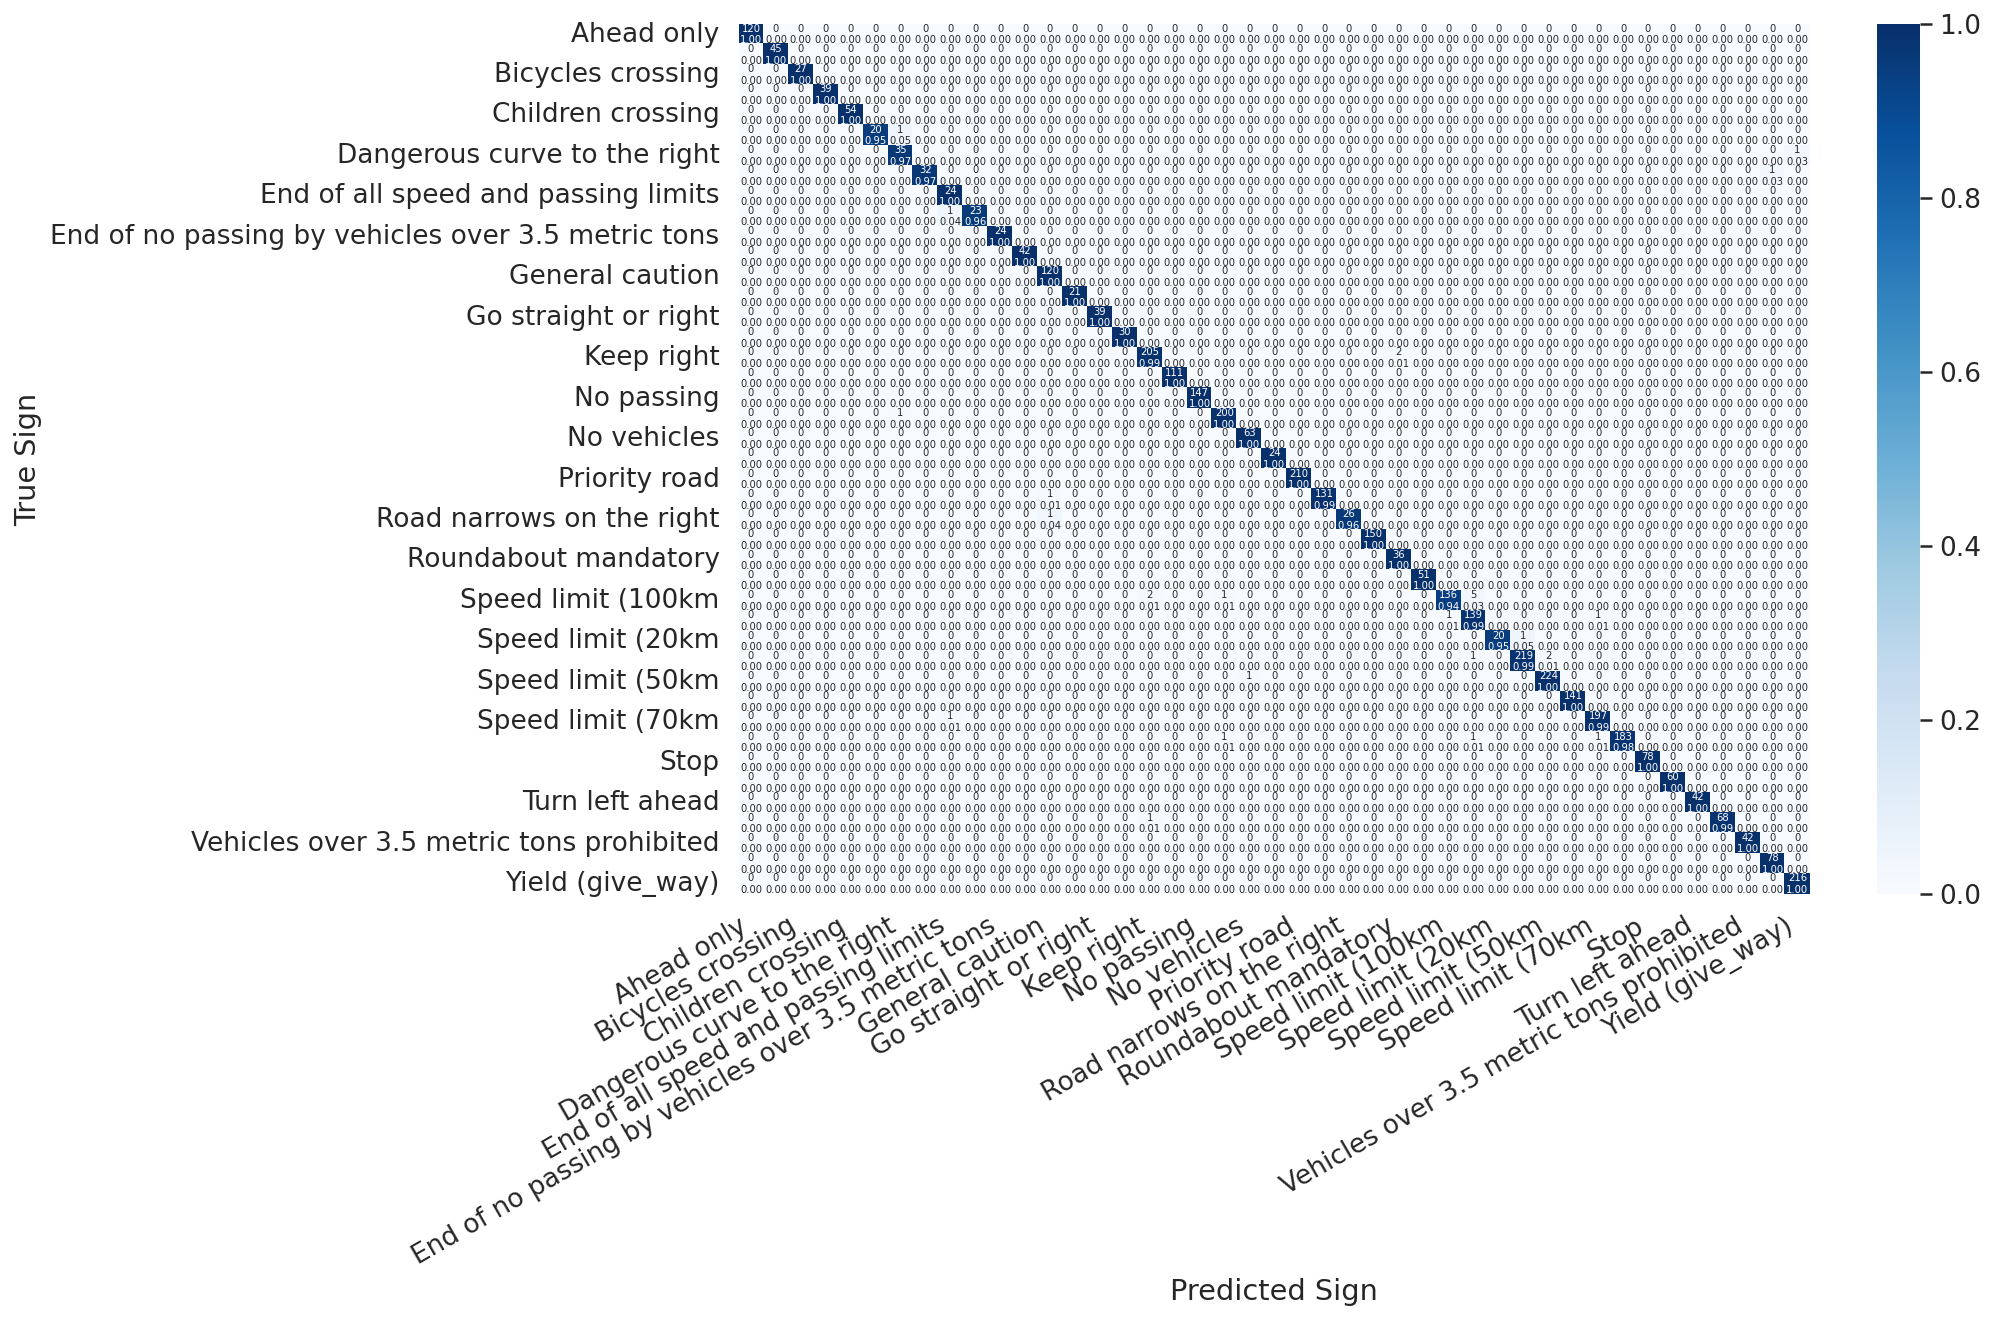

In [248]:
cm = confusion_matrix(y_test, y_pred)

show_confusion_matrix(cm, class_names)

## Classificazione immagine non vista


In [35]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 53.5MB/s]


Test Trasformazioni

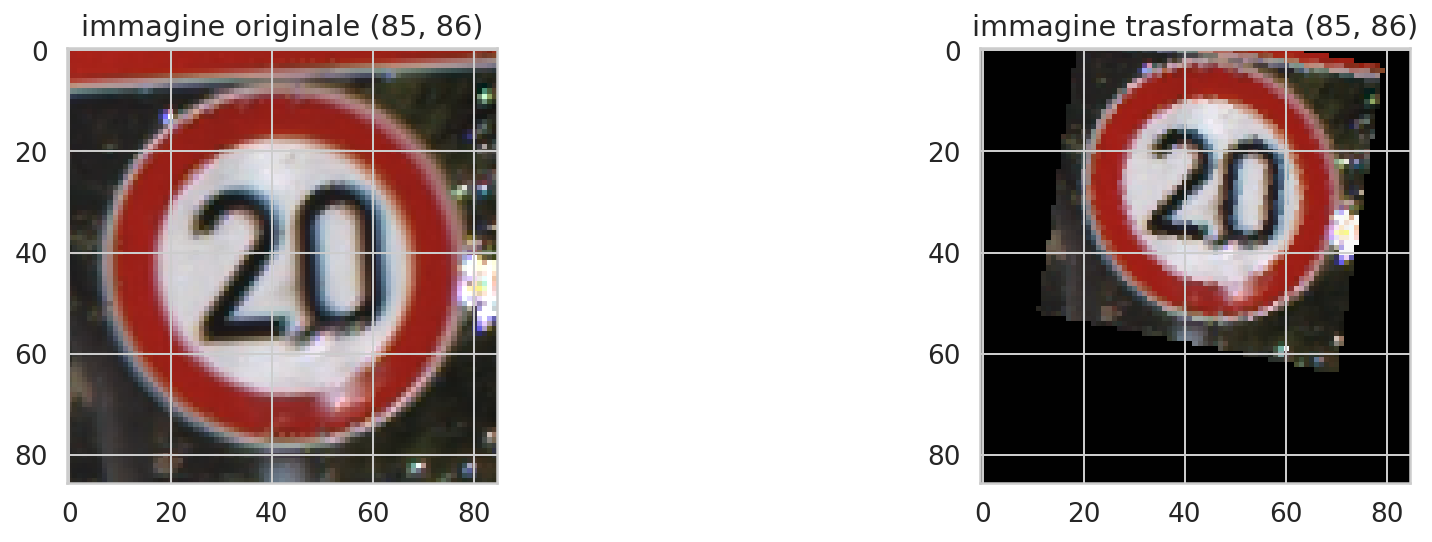

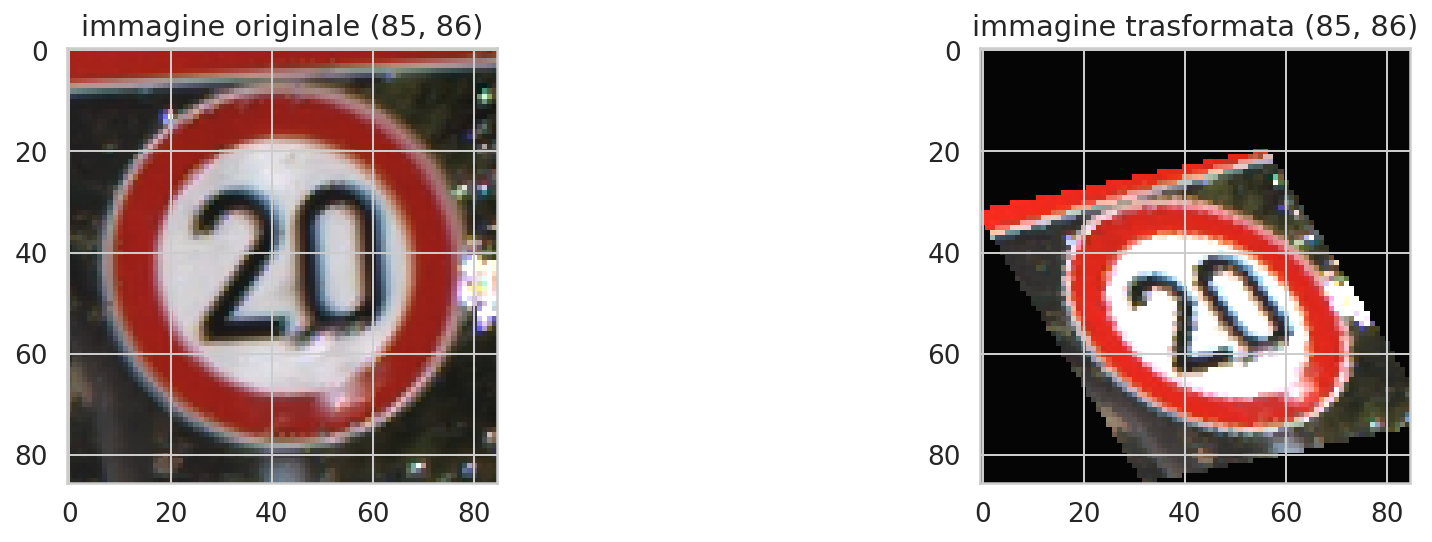

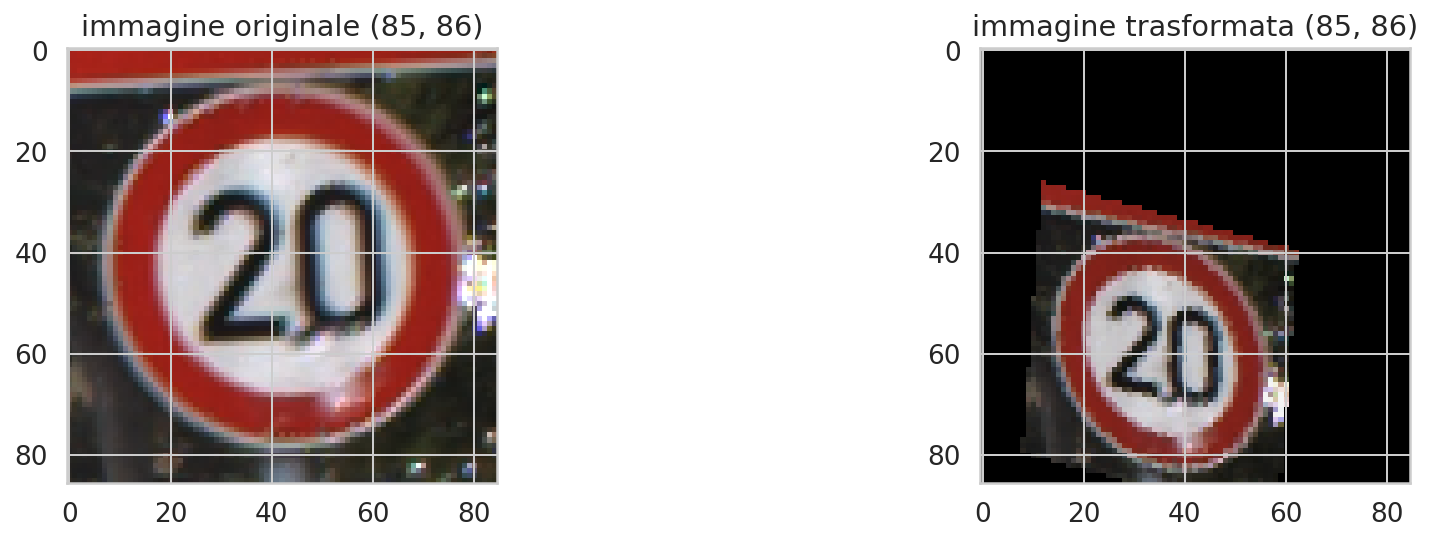

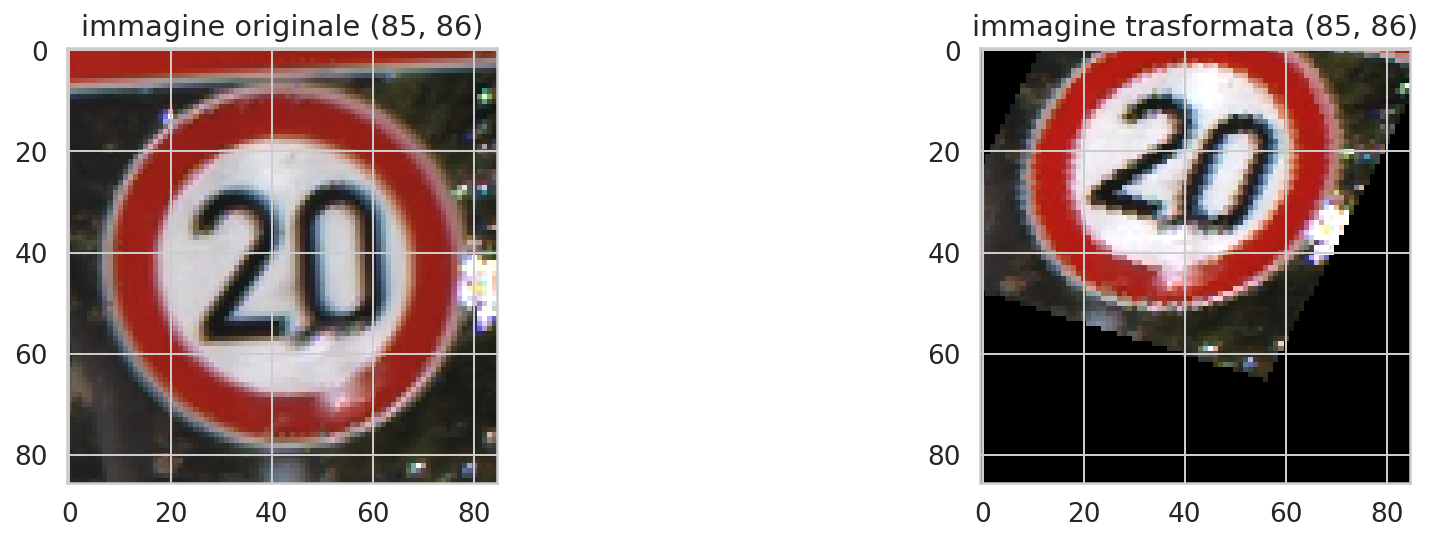

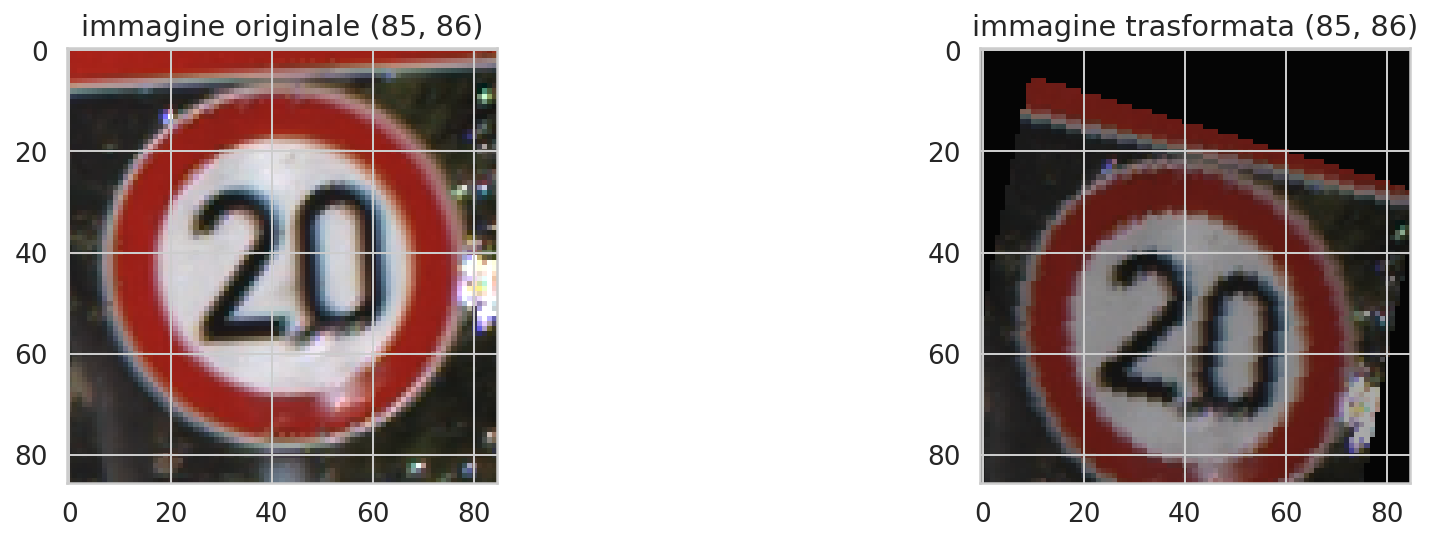

In [75]:
import PIL.Image
import matplotlib.pyplot as plt
#show_image('stop-sign.jpg')

#tran = T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75), shear=(-10, 10))
tran = T.Compose([ T.RandomAffine(degrees=(-30, 30), translate=(0.1,0.3), scale=(0.6,1), shear=(-20, 20)),
T.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.2, hue=0)])


def imshowTra(img, transform):
    """
    :param img: Path dell'immagine
    :param transform: data augmentation da applicare"""
    img = PIL.Image.open(img)
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set_title(f'immagine originale {img.size}')
    ax[0].imshow(img)
    img = transform(img)
    ax[1].set_title(f'immagine trasformata {img.size}')
    ax[1].imshow(img)
for i in range(5):
  imshowTra('/content/00000_00000_00025.png',tran)

Predizione con confidenza rispetto a tutte le classi possibili

In [251]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [252]:
pred = predict_proba(base_model, 'stop-sign.jpg')
pred

array([8.89921444e-04, 5.24785370e-04, 1.29257073e-03, 3.95305105e-04,
       3.39800725e-03, 1.07646963e-04, 1.69569015e-04, 2.27457756e-04,
       9.02811735e-05, 6.58338424e-04, 8.57558218e-04, 9.09140508e-05,
       5.57114487e-04, 4.47350001e-04, 6.04379165e-04, 1.14790746e-04,
       1.50905427e-04, 3.01071495e-01, 1.03325006e-02, 4.37724218e-03,
       4.43351950e-04, 2.74590886e-04, 1.28669478e-02, 9.23385285e-03,
       3.95863259e-04, 1.72452838e-03, 1.07022561e-03, 1.10132981e-03,
       4.10958612e-03, 4.51689493e-03, 2.83852266e-03, 1.18395186e-03,
       1.27536093e-03, 1.64098362e-03, 8.23989511e-04, 6.65523112e-04,
       4.87328738e-01, 3.31709813e-03, 1.26315595e-03, 2.34902182e-04,
       1.37951551e-03, 2.35460193e-05, 1.35929435e-01], dtype=float32)

Plot confidenza

In [253]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

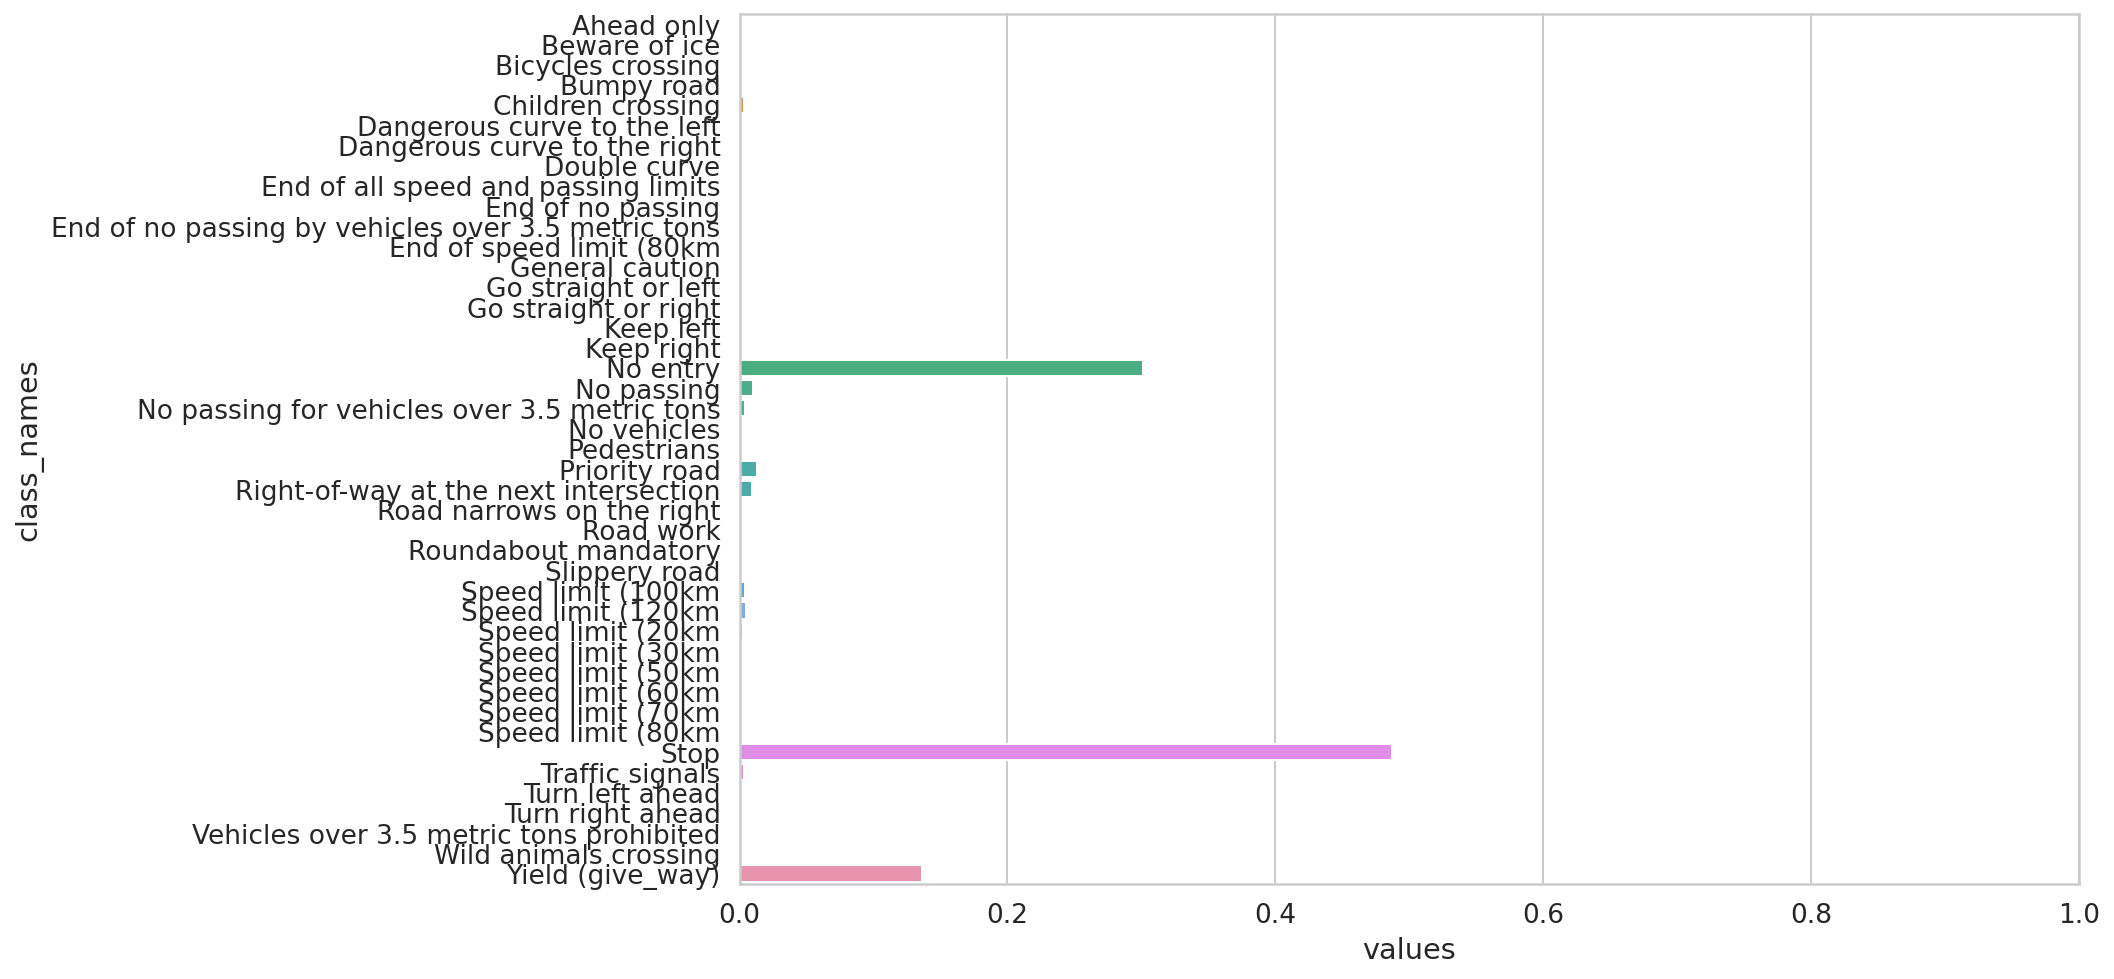

In [254]:
show_prediction_confidence(pred, class_names)